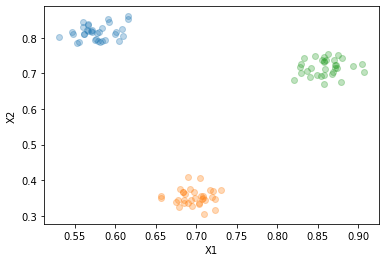

array([2, 1, 2, 0, 1, 2, 2, 2, 2, 1, 1, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 1,
       2, 1, 1, 2, 2, 0, 1, 2, 0, 1, 2, 1, 0, 2, 2, 0, 0, 1, 0, 0, 0, 2,
       0, 1, 0, 0, 2, 2, 0, 2, 0, 2, 1, 1, 0, 1, 2, 2, 0, 0, 2, 0, 0, 1,
       0, 2, 2, 0, 2, 0, 0, 1, 0, 0, 2, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 2,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 2, 2, 1])

In [356]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import label_binarize

def geradataset(tamanho=20, centros=2):
    X, y = make_blobs(n_samples=tamanho, centers=centros, center_box=(0, 1.0), cluster_std=0.02)
    return X, y

def plotadataset(X, y):
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

def plotahiperplano(vetor, bias=0, xmin=0, xmax=1):
    xs = np.linspace(xmin, xmax, num=2)
    ys = (-vetor[0] / vetor[1]) * xs - bias / vetor[1]
    plt.plot(xs,ys)

X, y = geradataset(100,3)
plotadataset(X, y)
plt.show()
y

In [357]:
class CustoPerceptron():
    @staticmethod
    def erro(y, ypred):
        return y - ypred
    @staticmethod
    def custo(y, ypred):
        return np.sum(CustoPerceptron.erro(y, ypred)**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return np.matmul(X.T, CustoPerceptron.erro(y, ypred))

class Adaline():
    def __init__(self):
        self.preactivated = True
    @staticmethod
    def erro(y, ypred):
        return y - ypred
    @staticmethod
    def custo(y, ypred):
        return np.sum((1 - Adaline.erro(y, ypred))**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return np.matmul(X.T, Adaline.erro(y, ypred))

In [358]:
from sklearn.base import BaseEstimator, ClassifierMixin

class Perceptron(BaseEstimator, ClassifierMixin):
    def __init__(self, custo=Adaline()):
        self.w = None
        self.maxiter = 1000
        self.alpha = 0.005
        self.threshold = 0
        self.activation = lambda a: (a >= 0) * 2 - 1
        self.custo = custo
    
    @staticmethod
    def includebias(X):
        bias = np.ones((X.shape[0],1))
        Xb = np.concatenate((bias,X), axis=1)
        return Xb
    
    def fit(self, X, y):
        X = Perceptron.includebias(X)
        self.labels = list(set(y))
        y = label_binarize(y, classes=self.labels)*2-1
        if len(self.labels) == 2 :
            y = y[:,0:1]
        # treinamento
        self.w = np.random.uniform(-1, 1, size=(X.shape[1], y.shape[1]))
        for _ in range(self.maxiter):
            a = np.matmul(X, self.w)
            if (hasattr(self.custo, 'preactivated') and self.custo.preactivated):
                ypred = a
            else:
                ypred = self.activation(a)
            custo = self.custo.custo(y, ypred)
            if custo == 0:
                break
            self.w = self.w + self.alpha*self.custo.gradiente(y, ypred, X)

    def predict(self, X):
        Xb = Perceptron.includebias(X)
        a = np.matmul(Xb, self.w)
        if self.w.shape[1] > 1:
            idx = np.argmax(a, axis=1) 
        else:
            idx = np.array(self.activation(a) > self.threshold, dtype=int)[:,0]
        ypred = np.array([self.labels[i] for i in idx])
        return ypred



1.0
[[-5.90943292 -1.51493527  7.40767609]
 [ 2.73256188 -4.67057792  1.93420173]] [ 2.15210374  3.68058437 -6.81831354]


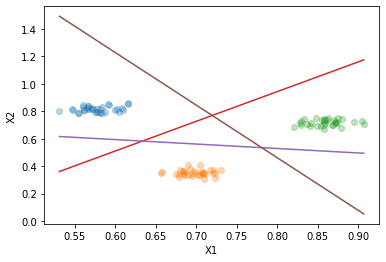

In [373]:
perceptron = Perceptron(Adaline())
perceptron.fit(X, y)
ypred = perceptron.predict(X)
print(sum(y == ypred)/len(y))
print(perceptron.w[1:], perceptron.w[0])
plotadataset(X, y)
if len(set(y)) > 2:
    for i in range(len(set(y))):
        plotahiperplano(perceptron.w[1:,i], perceptron.w[0,i], min(X[:,0]), max(X[:,0]))
else:
    plotahiperplano(perceptron.w[1:],perceptron.w[0])

1.0
[[-0.76169663  0.58190118  1.0406759 ]
 [ 0.83626636 -1.0285943  -0.06187879]] [-0.18811419  0.1355549  -0.79338869]


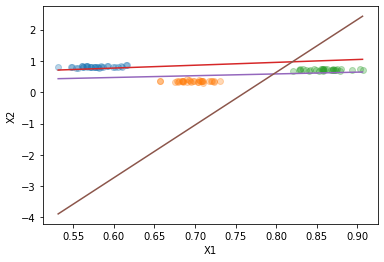

In [368]:
perceptron = Perceptron(CustoPerceptron())
perceptron.fit(X, y)
ypred = perceptron.predict(X)
print(sum(y == ypred)/len(y))
print(perceptron.w[1:], perceptron.w[0])
plotadataset(X, y)
if len(set(y)) > 2:
    for i in range(len(set(y))):
        plotahiperplano(perceptron.w[1:,i], perceptron.w[0,i], min(X[:,0]), max(X[:,0]))
else:
    plotahiperplano(perceptron.w[1:],perceptron.w[0])